# 模型选择、欠拟合和过拟合
## 训练误差和泛化误差
为了进一步讨论这一现象，我们需要了解训练误差和泛化误差。
*训练误差*（training error）是指，
模型在训练数据集上计算得到的误差。
*泛化误差*（generalization error）是指，
模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

问题是，我们永远不能准确地计算出泛化误差。
这是因为无限多的数据样本是一个虚构的对象。
在实际中，我们只能通过将模型应用于一个独立的测试集来估计泛化误差，
该测试集由随机选取的、未曾在训练集中出现的数据样本构成。
## 模型选择
在机器学习中，我们通常在评估几个候选模型后选择最终的模型。
这个过程叫做*模型选择*。
有时，需要进行比较的模型在本质上是完全不同的（比如，决策树与线性模型）。
又有时，我们需要比较不同的超参数设置下的同一类模型。

例如，训练多层感知机模型时，我们可能希望比较具有
不同数量的隐藏层、不同数量的隐藏单元以及不同的激活函数组合的模型。
为了确定候选模型中的最佳模型，我们通常会使用验证集。
### 验证集
原则上，在我们确定所有的超参数之前，我们不希望用到测试集。
如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险。
然而，我们也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。
解决此问题的常见做法是将我们的数据分成三份，
除了训练和测试数据集之外，还增加一个*验证数据集*（validation dataset），
也叫*验证集*（validation set）。
但现实是验证数据和测试数据之间的边界模糊得令人担忧。
除非另有明确说明，否则在这本书的实验中，
我们实际上是在使用应该被正确地称为训练数据和验证数据的数据集，
并没有真正的测试数据集。
因此，书中每次实验报告的准确度都是验证集准确度，而不是测试集准确度。

### $K$折交叉验证

当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集。
这个问题的一个流行的解决方案是采用$K$*折交叉验证*。
这里，原始训练数据被分成$K$个不重叠的子集。
然后执行$K$次模型训练和验证，每次在$K-1$个子集上进行训练，
并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。
最后，通过对$K$次实验的结果取平均来估计训练和验证误差。

## 欠拟合还是过拟合
当训练误差和验证误差都很严重，但它们之间仅有一点差距，我们有理由相信可以用一个更复杂的模型降低训练误差，这种现象被称为*欠拟合*（underfitting）。

另一方面，我们的训练误差明显低于验证误差时，
这表明严重的*过拟合*（overfitting）。
注意，*过拟合*并不总是一件坏事。
特别是在深度学习领域，众所周知，
最好的预测模型在训练数据上的表现往往比在保留（验证）数据上好得多。
最终，我们通常更关心验证误差，而不是训练误差和验证误差之间的差距。

是否过拟合或欠拟合可能取决于模型复杂性和可用训练数据集的大小，模型复杂数据量小容易造成过拟合，模型简单数据量大容易造成欠拟合。

几个影响模型复杂性的因素：

1. 可调整参数的数量
1. 参数采用的值
1. 模型类型

## 多项式回归
我们现在可以通过多项式拟合来探索这些概念。

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
from d2l import torch as d2l
import warnings 
warnings.filterwarnings('ignore')

### 生成数据集
给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。


In [4]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)  # gamma(n) = (n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [11]:
features.shape

(200, 1)

In [12]:
labels.shape

(200,)

In [18]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

### 对模型进行训练和测试
首先我们实现一个函数来评估模型在给定数据集上的损失：

In [20]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

现在定义训练函数：


In [15]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合（正常）
我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。


weight: [[ 4.994742   1.2177728 -3.4137876  5.570047 ]]


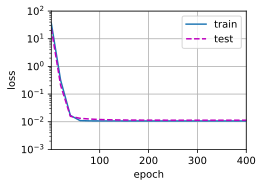

In [21]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 线性函数拟合（欠拟合）
让我们再看看线性函数拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[2.937727  5.5258465]]


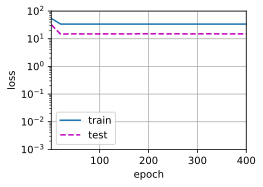

In [22]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合（过拟合）
现在，让我们尝试使用一个阶数过高的多项式来训练模型。
在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。
虽然训练损失可以有效地降低，但测试损失仍然很高。
结果表明，复杂模型对数据造成了过拟合。

weight: [[ 5.0079422e+00  1.2473880e+00 -3.4616923e+00  5.3788428e+00
   6.1336674e-02  7.2732621e-01  4.6274248e-01 -3.4227407e-01
   3.6920038e-01 -2.3490505e-02  7.1383238e-02  1.8310893e-01
  -3.0918003e-03  5.0771289e-02  3.2514792e-02 -4.7997348e-02
  -5.6644283e-02  3.3518737e-03  4.1878898e-02 -1.9185272e-01]]


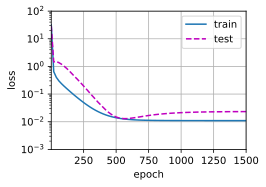

In [23]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

在接下来的章节中，我们将继续讨论过拟合问题和处理这些问题的方法，例如权重衰减和dropout。

## 小结

* 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。
* 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。
* 验证集可以用于模型选择，但不能过于随意地使用它。
* 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。